<!--HEADER-->
*Documentation for the EpiSiming epidemic simulation package*

<!--BADGES-->
<a href="https://colab.research.google.com/github/episiming/epsiming/blob/master/notebooks/01.05-Atributos_de_susceptibilidade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a><a href="https://mybinder.org/v2/gh/episiming/episiming/master?filepath=notebooks/01.05-Atributos_de_susceptibilidade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open in Binder"></a><a href="https://nbviewer.jupyter.org/github/episiming/episiming/blob/master/notebooks/01.05-Atributos_de_susceptibilidade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://raw.githubusercontent.com/episiming/episiming/master/notebooks/01.05-Atributos_de_susceptibilidade_e_infectividade.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/download-notebook-9cf" alt="Download Notebook" title="Download Notebook"></a>&nbsp;

<!--NAVIGATOR-->
[<- Construção do atributo de idade](01.04-Atributos_de_idade_e_infectividade.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Analisando o cenário ->](01.06-Cenario_completo.ipynb)

---


# Construção dos atributos de idade e infectividade potencial relativa dos indivíduos

- Vamos ver, agora, como construir os atributos restantes:

    - **idade**.
    
    - **grau relativo de potencial de infectividade**.

In [1]:
import datetime

import os, sys

import yaml

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
%cd ..
import episiming

/Users/rrosa/Documents/git_repositories/episiming


In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 07/Oct/2020


## Representação dos indivíduos

- Para cada **índice** $i=1, \ldots, N$ de uma população de $N$ indivíduos, queremos definir

    - A **idade** $a_i$ do indivíduo.
    
    - O **grau relativo de susceptibilidade** $\rho^\textrm{sus}_i$ do indivíduo.

    - O **grau relativo de infectividade** $\rho^\textrm{inf}_i$ do indivíduo.
    
- O grau de infectividade, naturalmente, é um grau potencial, que só é efetivo caso o indivíduo se torne infectado.

## Construção dos atributos

- Para a definição das **idades**:

    - Usamos a **pirâmide etária** do Rio de Janeiro.
    
    - Usamos certas condições nas idades dependendo do **tamanho da residência** em que habitam.
        
- No momento, definimos o **grau relativo de susceptibilidade** como sendo igual a $1$ para todos os indivíduos, mas posteriormente isso pode se tornar um parâmetro aleatório.

- Para a definição do **grau de infectividade**:

    - Usamos a **distribuição gamma** com fatores de forma $\alpha=\beta=0.2$, para uma média igual a $1$, conforme feito pelo grupo do *Imperial/Pitt*.

## Grau relativo de susceptibilidade

- Conforme mencionado acima, tomamos, nesse primeiro momento, $\rho^\textrm{sum}_i = 1$, para todos os indivíduos $i=1, \ldots, N$

## Grau relativo de infectividade

- Cada indivíduo tem um potencial maior ou menor de transmitir a doença, de acordo com as suas características.

- Para levar isso em consideração, um parâmetro relativo (adimensional) $\rho_i$ é definido para cada indivíduo.

- Este parâmetro é tomado de acordo com uma [distribuição gama](https://en.wikipedia.org/wiki/Beta_distribution) com média 1 (ver [DeGroot & Schervish (2012)](#Referências)).

- Uma distribuição gama é caracterizada por dois *fatores de forma*, $\alpha$ e $\beta$.

- Com esses fatores, a função densidade de probabilidade (PDF) de gama é

$$
\begin{align}
f(x;\alpha,\beta) & = \frac{ \beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)} \quad \textrm{para } x > 0, \quad \textrm{com } \alpha, \beta > 0,
\end{align}
$$

- Acima, temos a função gama $\Gamma(\alpha) = \int_0^\infty x^{\alpha-1} e^{-x} \;\textrm{d}x$, necessária para que a integral de $f(x;\alpha,\beta)$ em $(0,\infty)$ seja 1 e, portanto, que ela seja a função densidade de uma probabilidade.

- Dados os parâmetros $\alpha$ e $\beta$, a distribuição gama tem como valor médio 

$$ \textrm{valor médio} = \frac{\alpha}{\beta}.
$$

- Como queremos média $1$, precisamos que $\alpha=\beta$.

- No nosso modelo, usamos os mesmos parâmetros utilizados pelo grupo do Imperial/Pitt, ver [Ferguson el al (2005)](#Referências), a saber $\alpha = \beta = 0.2$.

### Definindo a infectividade pelo scipy

- Utilizamos a função [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) para distribuir os valores de $\rho_i$.

- Também podemos utilizar [numpy.random.gamma](https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html).

- E utilizamos o método `scipy.stats.gamma.pdf` para visualizar a PDF da distribuição com esses parâmetros.

- Observe que o `scipy` define a função gama com parâmetros `a`, `loc` e `scale`:

```python
gamma.pdf(x, a, loc, scale) = gamma.pdf((x - loc) / scale, a) / scale
```

onde `gamma.pdf(x, a)` é dada por $x^{a-1}e^{-x}/\Gamma(a)$, ou seja,

$$ \textrm{gamma.pdf(x, a, loc, scale)} = \frac{(x-\textrm{loc})^{a-1}}{\textrm{scale}^a}\frac{\exp\left(-\frac{x-\textrm{loc}}{\textrm{scale}}\right)}{\Gamma(a)}.
$$

- Acima, `a` representa o parâmetro $\alpha$ e `loc` é um *deslocamento* na abcissa, que, no nosso caso, não estamos considerando. Por fim, `scale` é o inverso de $\beta$ (é o termo `k` na outra representação vista em [distribuição gama](https://en.wikipedia.org/wiki/Beta_distribution) e também o nome do argumento usado por [numpy.random.gamma](https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html)). 

- Assim, para o nosso caso, temos

$$ \textrm{gamma.pdf(x, a=alpha, loc=0, scale=1/beta)} = \beta^\alpha x^{\alpha-1}\frac{e^{-\beta x}}{\Gamma(\alpha)} = f(x; \alpha, \beta),
$$

### Construindo a distribuição da infectividade

- Abaixo, alguns gráficos para visualizar a distribuição de $\rho_i$ na população.

- Tomamos uma população de 1000 indivíduos para ilustrar.

- E fazemos `a` = $\alpha = 0.8$ e `scale` = $1/\beta = 1.25$ em [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html).

In [5]:
num_pop = 1000
#rho_forma = 0.5
#rho_escala = 2
rho_forma = 0.8
rho_escala = 1.25
ppf_min = 0.45
ppf_max = 0.95
gamma_x = np.linspace(stats.gamma.ppf(ppf_min, a=rho_forma, scale=rho_escala),
                      stats.gamma.ppf(ppf_max, a=rho_forma, scale=rho_escala),
                      200)
gamma_pdf = stats.gamma.pdf(gamma_x, a=rho_forma, scale=rho_escala)
rho = stats.gamma.rvs(a=rho_forma, scale=rho_escala, size=num_pop)
#rho = np.random.gamma(rho_forma, rho_escala, num_pop)
#%timeit rho = np.random.gamma(shape=rho_forma, scale=rho_escala, size=num_pop)
#%timeit rho = stats.gamma.rvs(a=rho_forma, scale=rho_escala, size=num_pop)
print('rho_i gerado de acordo com a distribuição gama')
print(f'- fator de forma: {rho_forma}')
print(f'- escala: {rho_escala}')
print(f'- valor médio: {rho_escala *rho_forma}')

rho_i gerado de acordo com a distribuição gama
- fator de forma: 0.8
- escala: 1.25
- valor médio: 1.0


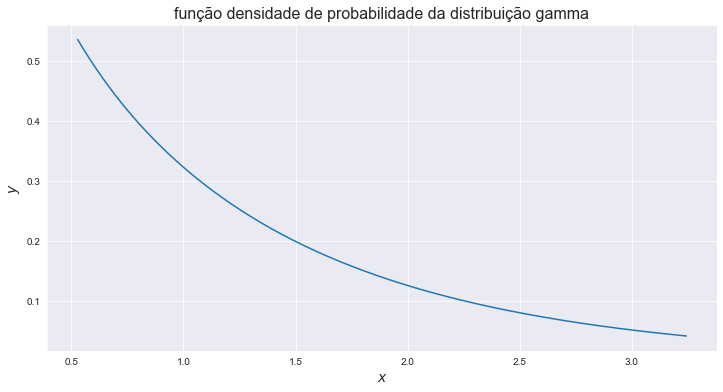

In [6]:
plt.figure(figsize=(12,6))
plt.plot(gamma_x, gamma_pdf)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'função densidade de probabilidade da distribuição gamma',
          fontsize=16)
plt.show()

### Visualizando a distribuição da infectividade

- A seguir, alguns gráficos para visualizar a distribuição de $\rho_i$ na população.

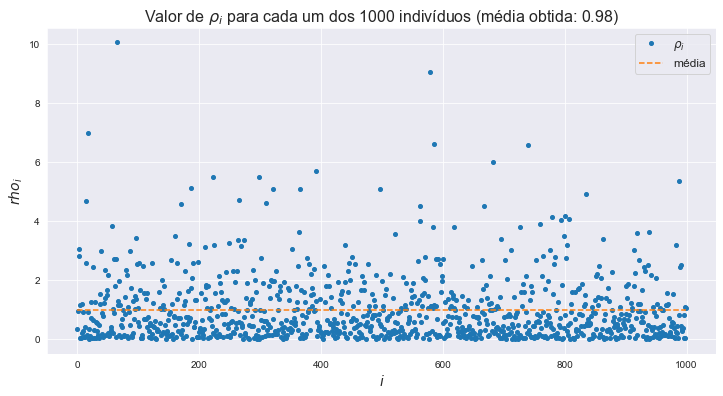

In [7]:
plt.figure(figsize=(12,6))
plt.plot(rho, 'o', markersize=4, label=r'$\rho_i$')
plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$rho_i$', fontsize=14)
plt.legend(fontsize=12)
plt.title(r'Valor de $\rho_i$ para cada um dos' + f' {num_pop} indivíduos' 
          + f' (média obtida: {np.mean(rho):.2f})', fontsize=16)
plt.show()

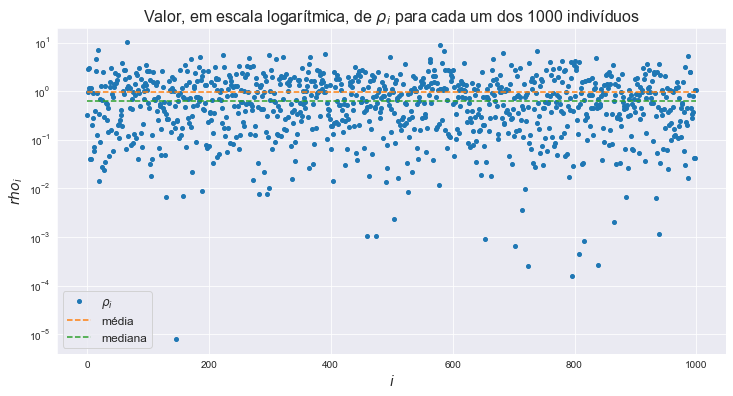

In [8]:
plt.figure(figsize=(12,6))
plt.plot(rho, 'o', markersize=4, label=r'$\rho_i$')
plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.plot(range(num_pop), np.median(rho)*np.ones(num_pop), '--', label='mediana')
plt.xlabel(r'$i$', fontsize=14)
plt.ylabel(r'$rho_i$', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=12)
plt.title(r'Valor, em escala logarítmica, de $\rho_i$ para cada um dos'
          + f' {num_pop} indivíduos', fontsize=16)
plt.show()

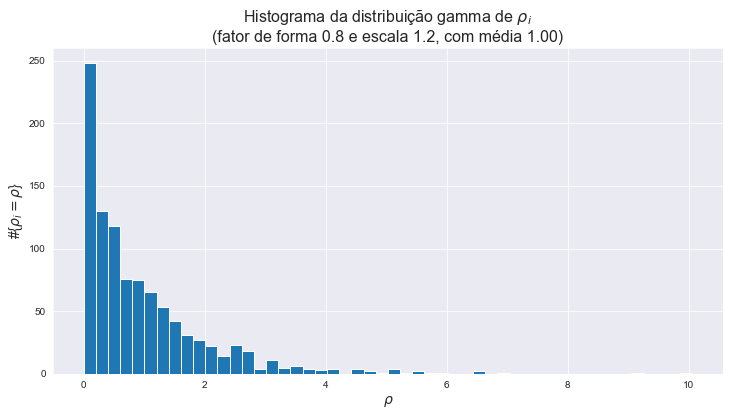

In [9]:
plt.figure(figsize=(12,6))
plt.hist(rho, bins=50)
#plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'#{$\rho_i=\rho$}', fontsize=14)
#plt.yscale('log')
plt.title(r'Histograma da distribuição gamma de $\rho_i$'
          + f'\n(fator de forma {rho_forma:.1f} e escala {rho_escala:.1f}, com média {rho_forma*rho_escala:.2f})',
          fontsize=16)
plt.show()

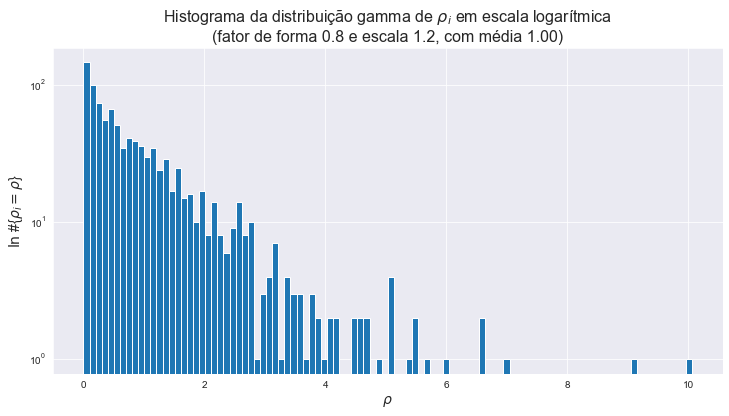

In [10]:
plt.figure(figsize=(12,6))
plt.hist(rho, bins=100)
#plt.plot(range(num_pop), np.mean(rho)*np.ones(num_pop), '--', label='média')
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$\ln$ #{$\rho_i=\rho$}', fontsize=14)
plt.yscale('log')
plt.title(r'Histograma da distribuição gamma de $\rho_i$ em escala logarítmica'
          + f'\n(fator de forma {rho_forma:.1f} e escala {rho_escala:.1f}, com média {rho_forma*rho_escala:.2f})',
          fontsize=16)
plt.show()

## Referências

- [DeGroot MH, Schervish MJ (2012), Probability and Statistics, 4th edition, Pearson Education, Inc.](https://www.pearson.com/us/higher-education/program/De-Groot-Probability-and-Statistics-4th-Edition/PGM146802.html).

<!--NAVIGATOR-->

---
[<- Construção do atributo de idade](01.04-Atributos_de_idade_e_infectividade.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Analisando o cenário ->](01.06-Cenario_completo.ipynb)